In [1]:
import os
import glob

import numpy as np
import pandas as pd
import parmed as pmd
import matplotlib.pyplot as plt

import MDAnalysis as mda
from tqdm import tqdm
from numpy import linalg as LA
from MDAnalysis.analysis import distances

In [2]:
runs = sorted(glob.glob("../../traj_save/*//*.pdb"))

# energy calculation 
1. Lennard Jones interaction 
$$ 
\sigma_{ij} = \frac{1}{2}  (\sigma_{ii} + \sigma_{jj}) \\
\epsilon_{ij} = \sqrt(\epsilon_{ii} \epsilon_{jj})  \\
V_{LJ}(r_{ij}) = 4 \epsilon_{ij} \left[ \left(\frac{\sigma_{ij}}{r_{ij}} \right)^{12} - \left(\frac{\sigma_{ij}}{r_{ij}} \right)^{6} \right]
$$
2. Coulombic interaction 
$$
V_{C} (r_{ij}) = f \frac{q_i q_j}{\varepsilon_r r_{ij}} \\ 
f = \frac{1}{4 \pi \varepsilon_0} = 139.935485 ~ kJ \cdot mol^{-1} \cdot nm \cdot e^{-2}
$$

In [49]:
def cal_LJ(atom1, atom2, dist): 
    sigma_ij = (atom1.sigma + atom2.sigma) / 2
    epsilon_ij = (atom1.epsilon * atom2.epsilon) ** 0.5
    V_lj = 4 * epsilon_ij * ((sigma_ij/dist)**12 - (sigma_ij/dist)**6) 
    return V_lj


def cal_Coul(atom1, atom2, dist): 
    f = 139.935485 
    q_i = atom1.charge
    q_j = atom2.charge 
    V_coul = f * q_i * q_j / dist 
    return V_coul

In [46]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.01)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)

In [48]:
xx.shape, yy.shape, z.shape

((1, 100), (1000, 1), (1000, 100))

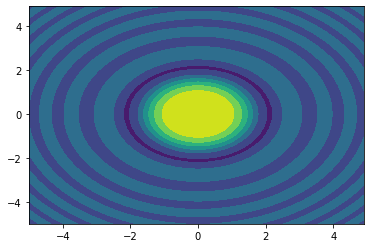

In [45]:
h = plt.contourf(x,y,z)
plt.show()

In [42]:
xx.shape

(1, 100)

In [32]:
atom1 = top.atoms[11]
atom2 = top.atoms[10]
atom1, atom2

(<Atom O [11]; In ALA 0>, <Atom C [10]; In ALA 0>)

(-1.0, 5.0)

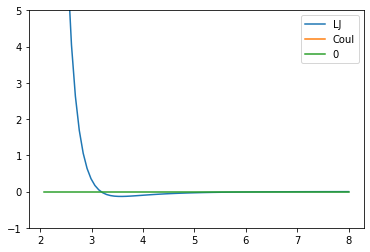

In [37]:
dists = np.linspace(2, 8, 80)[1:]
lj_prof = [cal_LJ(atom1, atom2, i)for i in dists]
coul_prof = [cal_Coul(atom1, atom2, i)for i in dists] 

plt.plot(dists, lj_prof, label='LJ') 
plt.plot(dists, coul_prof, label='Coul')
plt.plot(dists, np.zeros_like(dists), label='0')

plt.legend()
plt.ylim([-1, 5])


In [54]:
df = []

for run in runs[:2]:
    pdb_file = run
    dcd_file = run.replace("pdb", "dcd")

    run_base = os.path.basename(run)[:-4]
    if run.split('/')[-2] == 'Nsp10_Nsp16': 
        run_base += '_000'
#     print(run_base)
    top_file = f'../../traj_save/top_files/{run_base[:-4]}.top'
    resname = run_base.split('_')[1] if len(run_base.split('_')) > 3 else None
    print(resname)

    mda_traj = mda.Universe(pdb_file, dcd_file)
    top = pmd.load_file(top_file, xyz=pdb_file)

    nsp16 = mda_traj.segments[0].atoms
    if resname: 
        nsp16 = nsp16 + mda_traj.select_atoms(f"resname {resname}") 
    
    nsp10 = mda_traj.select_atoms("segid B")
    ZN = mda_traj.select_atoms("resname ZN")
    nsp10 = nsp10 + ZN

    dist_list = []
    for ts in tqdm(mda_traj.trajectory[:10]):
        dist_map  = distances.distance_array(
                nsp10.positions, nsp16.positions, box = ts.dimensions) 
        
        df.append({'sys_name': run_base,
                    'frame': ts.frame,
    #                    'dist_vec': dist_vec,
                   'dist': dist_map})

None


100%|██████████| 10/10 [00:00<00:00, 10.24it/s]


None


100%|██████████| 10/10 [00:00<00:00, 10.25it/s]
